In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import gaussian_kde
import time
from sklearn.inspection import permutation_importance

# Machine learning libraries
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.neural_network import MLPRegressor

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Read data
prop = "stellar_mass"          # the property to predict

dat_train = pd.read_csv("Data/IllustrisTNG300-1-train.csv", header=0)
dat_test = pd.read_csv("Data/IllustrisTNG300-1-test.csv", header=0)

print(dat_train.shape)
print(dat_test.shape)

(123300, 16)
(41100, 16)


In [3]:
features = ["M200c", "sigma", "c200c", "z_form", "s", "q", "M_acc", "E_s", "Mean_vel", "f_mass_cen", "R0p9", "spin"]    # list of features
if prop == "stellar_mass":
    unit = r" $(\log_{{10}}(M_\odot/h))$"   # units of the target in the data (only used for plotting)
if prop == "radius":
    unit = r" $(\log_{{10}}(ckpc/h))$"
if prop == "SFR":
    features = ["M200c", "sigma", "c200c", "z_form", "s", "E_s", "Mean_vel", "f_mass_cen", "R0p9", "spin"]
    unit = r" $(\log_{{10}}(M_\odot/yr))$"
if prop == "color":
    features = ["M200c", "sigma", "c200c", "z_form", "s", "q", "M_acc", "E_s", "R0p9", "spin"]
    unit = " (u-i)"



plot_densities = True   # whether or not to plot point densities 
sample_size = 10000     # if plotting densities, plot a smaller sample since calculating densities takes a long time
if sample_size < 1:
    sample_size = int(sample_size*dat_test.shape[0])

save_figs = True        # whether to save the figures as png files
quantiles = [5, 95]

# Get x and y
x_train = dat_train[features]
y_train = dat_train[[prop]]
print(x_train.head())

x_test = dat_test[features]
y_test = dat_test[[prop]]

# standardize the data
x_test = (x_test-x_train.mean())/x_train.std()
x_train = (x_train-x_train.mean())/x_train.std()

y_test = y_test.to_numpy().reshape(-1,)
y_train = y_train.to_numpy().reshape(-1,)

print(x_test.shape, y_test.shape)

       M200c      sigma     c200c    z_form         s         q     M_acc  \
0  11.423144  67.867319  0.883694  1.078324  0.802845  0.944608  0.658514   
1  11.165382  57.869746  0.879829  1.254843  0.880211  0.917494 -0.495043   
2  11.588563  79.070478  0.865964  0.958822  0.800501  0.920170  0.246556   
3  11.600356  80.696796  0.872129  1.446222  0.825492  0.873398  0.846326   
4  10.964773  48.684645  0.985367  1.511623  0.805753  0.937950  0.229156   

         E_s    Mean_vel  f_mass_cen        R0p9      spin  
0  14.751925  459.700944    0.911639  130.850432  0.014209  
1  14.370393  816.064573    0.954870  107.874705  0.022668  
2  15.062748  228.316787    0.980968  148.124643  0.077505  
3  15.116039  144.685978    0.967982  149.866912  0.062712  
4  13.926382  296.311898    0.982056   87.822598  0.066108  
(41100, 12) (41100,)


R2 score: 0.93170214390464
correlation: 0.9652488522665392
mean squared error: 0.031197901439440935


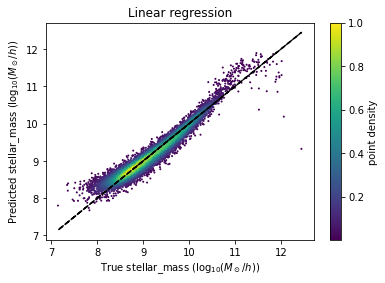

In [4]:
# linear regression
start = time.time()

LR_model = LinearRegression()

# Train
LR_model.fit(x_train, y_train)

# Predict
y_pred_LR = LR_model.predict(x_test)

t_LR = time.time() - start

# calculate performance measures
r2_LR = r2_score(y_test, y_pred_LR)
print(f"R2 score: {r2_LR}")

corr_LR = np.corrcoef(y_test, y_pred_LR)[0,1]
print(f"correlation: {corr_LR}")

mse_LR = mean_squared_error(y_test, y_pred_LR)
print(f"mean squared error: {mse_LR}")

# Plot true vs predicted
fig = plt.figure()
fig.patch.set_facecolor("white")

if plot_densities:
    if sample_size > 1:
        idx = np.random.choice(y_test.shape[0], size=sample_size, replace=False)
        xplot = y_test[idx]
        yplot = y_pred_LR[idx]
    else:
        xplot = y_test.copy()
        yplot = y_pred_LR.copy()

    # calculate densities
    xy = np.vstack([xplot, yplot])
    z = gaussian_kde(xy)(xy)

    # plot
    im = plt.scatter(xplot, yplot, s=1, c=z/max(z))
    plt.plot(xplot, xplot, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Linear regression")

    cbar = fig.colorbar(im)
    cbar.set_label("point density")

else:
    plt.scatter(y_test, y_pred_LR, s=1)
    plt.plot(y_test, y_test, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Linear regression")

if save_figs:
    plt.savefig(f"Figures/truevspred_LR_{prop}.png")
    

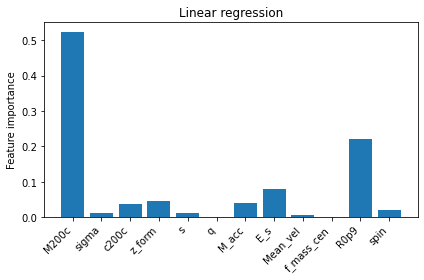

In [5]:
# plot feature importances
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(features, np.abs(LR_model.coef_)/sum(np.abs(LR_model.coef_)))
plt.ylabel("Feature importance")
plt.title("Linear regression")
plt.xticks(rotation=45, ha='right')

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/featureimportances_LR_{prop}.png")

In [6]:
quant = np.array(quantiles)/100

for i in range(len(quantiles)):
    model = sm.QuantReg(y_train, sm.add_constant(x_train))
    model = model.fit(q=quant[i])

    if i==0:
        y_pred_LR_q_lower = model.predict(sm.add_constant(x_test))

    elif i==1:
        y_pred_LR_q_upper = model.predict(sm.add_constant(x_test))

# calcualte the proportion of points within interval
CI_frac_LR = ((y_pred_LR_q_lower <= y_test) & (y_pred_LR_q_upper >= y_test)).sum()
CI_frac_LR /= len(y_test)
print(CI_frac_LR)



0.902360097323601


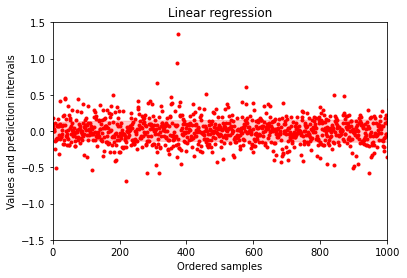

In [26]:

interval = y_pred_LR_q_upper - y_pred_LR_q_lower
sort_ind = np.argsort(interval)
upper = y_pred_LR_q_upper[sort_ind]
lower = y_pred_LR_q_lower[sort_ind]

# center so mean is at 0
mean = (upper+lower)/2
upper -= mean
lower -= mean

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(y_test[sort_ind] - mean, "r.")
plt.fill_between(np.arange(len(upper)), lower, upper, alpha=0.2, color="r")
plt.xlabel("Ordered samples")
plt.ylabel("Values and prediction intervals")
plt.title("Linear regression")

plt.xlim(0, 1000)


if save_figs:
    plt.savefig(f"Figures/confidenceintervals_LR_{prop}.png")

plt.show()




R2 score: 0.9480608380551021
correlation: 0.9736863308599722
mean squared error: 0.02372538389699427


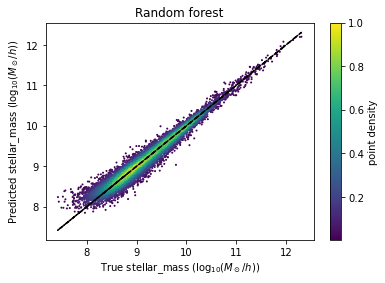

In [8]:
# random forest
start = time.time()

RF_model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10)

# Train
RF_model.fit(x_train, y_train)

# Predict
y_pred_RF = RF_model.predict(x_test)

t_RF = time.time() - start

# calculate performance measures
r2_RF = r2_score(y_test, y_pred_RF)
print(f"R2 score: {r2_RF}")

corr_RF = np.corrcoef(y_test, y_pred_RF)[0,1]
print(f"correlation: {corr_RF}")

mse_RF = mean_squared_error(y_test, y_pred_RF)
print(f"mean squared error: {mse_RF}")

# Plot true vs predicted
fig = plt.figure()
fig.patch.set_facecolor("white")

if plot_densities:
    if sample_size > 1:
        idx = np.random.choice(y_test.shape[0], size=sample_size, replace=False)
        xplot = y_test[idx]
        yplot = y_pred_RF[idx]
    else:
        xplot = y_test.copy()
        yplot = y_pred_RF.copy()

    # calculate densities
    xy = np.vstack([xplot, yplot])
    z = gaussian_kde(xy)(xy)

    # plot
    im = plt.scatter(xplot, yplot, s=1, c=z/max(z))
    plt.plot(xplot, xplot, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Random forest")

    cbar = fig.colorbar(im)
    cbar.set_label("point density")

else:
    plt.scatter(y_test, y_pred_RF, s=1)
    plt.plot(y_test, y_test, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Random forest")

if save_figs:
    plt.savefig(f"Figures/truevspred_RF_{prop}.png")

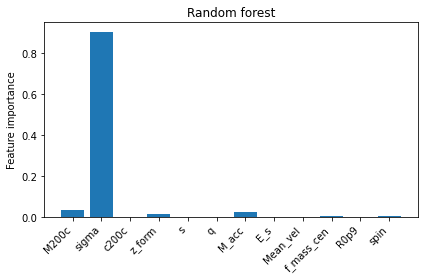

In [9]:
# plot feature importances
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(features, RF_model.feature_importances_/sum(RF_model.feature_importances_))
plt.ylabel("Feature importance")
plt.title("Random forest")
plt.xticks(rotation=45, ha='right')

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/featureimportances_RF_{prop}.png")

In [10]:
# random forest quantiles

# take smaller portion of data
idx = np.random.choice(x_train.shape[0], size=5000, replace=False)
x_train_s = x_train.to_numpy()[idx,:]
y_train_s = y_train[idx]

# create model
RF_model_q = RandomForestQuantileRegressor(n_estimators=50, min_samples_leaf=10)

# fit data
RF_model_q.fit(x_train_s, y_train_s)

# predict quantiles
y_pred_RF_q_lower = RF_model_q.predict(x_test, quantile=quantiles[0])
y_pred_RF_q_upper = RF_model_q.predict(x_test, quantile=quantiles[1])

# calcualte the proportion of points within interval
CI_frac_RF = ((y_pred_RF_q_lower <= y_test) & (y_pred_RF_q_upper >= y_test)).sum()
CI_frac_RF /= len(y_pred_RF)
print(CI_frac_RF)



/usr/lib/python3/dist-packages/sklearn/tree/_classes.py:323: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  warnings.warn("The parameter 'presort' is deprecated and has no "
/usr/lib/python3/dist-packages/sklearn/tree/_classes.py:323: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  warnings.warn("The parameter 'presort' is deprecated and has no "
/usr/lib/python3/dist-packages/sklearn/tree/_classes.py:323: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  warnings.warn("The parameter 'presort' is deprecated and has no "
/usr/lib/python3/dist-packages/sklearn/tree/_classes.py:323: 

0.9018004866180048


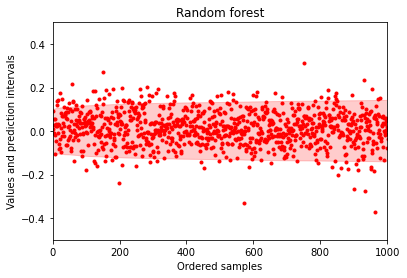

In [27]:
interval = y_pred_RF_q_upper - y_pred_RF_q_lower
sort_ind = np.argsort(interval)
upper = y_pred_RF_q_upper[sort_ind]
lower = y_pred_RF_q_lower[sort_ind]

# center so mean is at 0
mean = (upper+lower)/2
upper -= mean
lower -= mean

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(y_test[sort_ind] - mean, "r.")
plt.fill_between(np.arange(len(upper)), lower, upper, alpha=0.2, color="r")
plt.xlabel("Ordered samples")
plt.ylabel("Values and prediction intervals")
plt.title("Random forest")

plt.xlim(0, 1000)

if save_figs:
    plt.savefig(f"Figures/confidenceintervals_RF_{prop}.png")

plt.show()

R2 score: 0.9489620338703096
correlation: 0.9741498495337622
mean squared error: 0.023313725027626166


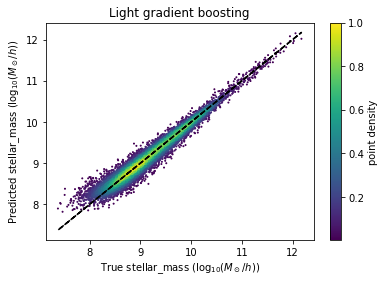

In [12]:
start = time.time()

LGBM_model = LGBMRegressor()

# Train
LGBM_model.fit(x_train, y_train)

# Predict
y_pred_LGBM = LGBM_model.predict(x_test)

t_LGBM = time.time() - start

# calculate performance measures
r2_LGBM = r2_score(y_test, y_pred_LGBM)
print(f"R2 score: {r2_LGBM}")

corr_LGBM = np.corrcoef(y_test, y_pred_LGBM)[0,1]
print(f"correlation: {corr_LGBM}")

mse_LGBM = mean_squared_error(y_test, y_pred_LGBM)
print(f"mean squared error: {mse_LGBM}")

# Plot true vs predicted
fig = plt.figure()
fig.patch.set_facecolor("white")

if plot_densities:
    if sample_size > 1:
        idx = np.random.choice(y_test.shape[0], size=sample_size, replace=False)
        xplot = y_test[idx]
        yplot = y_pred_RF[idx]
    else:
        xplot = y_test.copy()
        yplot = y_pred_RF.copy()

    # calculate densities
    xy = np.vstack([xplot, yplot])
    z = gaussian_kde(xy)(xy)

    # plot
    im = plt.scatter(xplot, yplot, s=1, c=z/max(z))
    plt.plot(xplot, xplot, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Light gradient boosting")

    cbar = fig.colorbar(im)
    cbar.set_label("point density")

else:
    plt.scatter(y_test, y_pred_RF, s=1)
    plt.plot(y_test, y_test, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Light gradient boosting")

if save_figs:
    plt.savefig(f"Figures/truevspred_LGBM_{prop}.png")

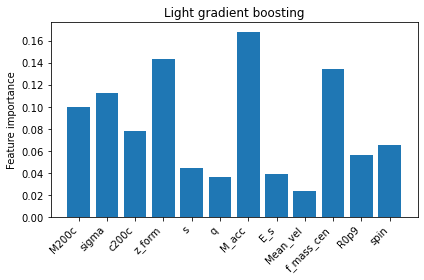

In [13]:
# plot feature importances
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(features, LGBM_model.feature_importances_/sum(LGBM_model.feature_importances_))
plt.ylabel("Feature importance")
plt.title("Light gradient boosting")
plt.xticks(rotation=45, ha='right')

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/featureimportances_LGBM_{prop}.png")

In [14]:
# lightgbm quantiles
quant = np.array(quantiles)/100

for i in range(len(quantiles)):
    lgbm = LGBMRegressor(alpha=quant[i], objective="quantile")
    lgbm.fit(x_train, y_train)

    if i==0:
        y_pred_LGBM_q_lower = lgbm.predict(x_test)

    elif i==1:
        y_pred_LGBM_q_upper = lgbm.predict(x_test)

# calcualte the proportion of points within interval
CI_frac_LGBM = ((y_pred_LGBM_q_lower <= y_test) & (y_pred_LGBM_q_upper >= y_test)).sum()
CI_frac_LGBM /= len(y_pred_LGBM)
print(CI_frac_LGBM)




0.8890510948905109


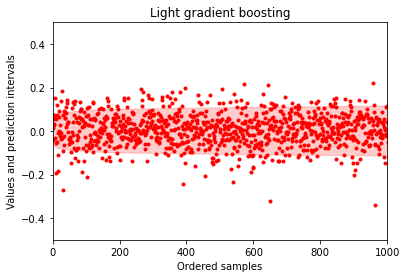

In [28]:
interval = y_pred_LGBM_q_upper - y_pred_LGBM_q_lower
sort_ind = np.argsort(interval)
upper = y_pred_LGBM_q_upper[sort_ind]
lower = y_pred_LGBM_q_lower[sort_ind]

# center so mean is at 0
mean = (upper+lower)/2
upper -= mean
lower -= mean

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(y_test[sort_ind] - mean, "r.")
plt.fill_between(np.arange(len(upper)), lower, upper, alpha=0.2, color="r")
plt.xlabel("Ordered samples")
plt.ylabel("Values and prediction intervals")
plt.title("Light gradient boosting")

plt.xlim(0, 1000)

if save_figs:
    plt.savefig(f"Figures/confidenceintervals_LGBM_{prop}.png")

plt.show()

/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


R2 score: 0.9344331813917782
correlation: 0.9666633582885725
mean squared error: 0.029950385877134052


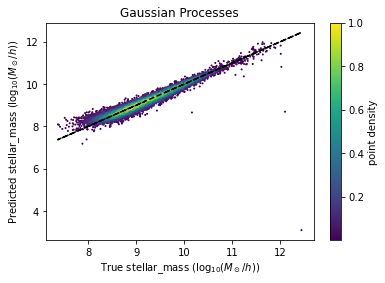

In [16]:
start = time.time()

kernel = ConstantKernel() * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))

GPR_model = GaussianProcessRegressor(kernel=kernel)

# Train with smaller subset of data
idx = np.random.choice(x_train.shape[0], size=5000, replace=False)
x_train_s = x_train.to_numpy()[idx,:]
y_train_s = y_train[idx]
GPR_model.fit(x_train_s, y_train_s)

# Predict
y_pred_GPR, y_std = GPR_model.predict(x_test, return_std=True)

t_GPR = time.time() - start

# calculate performance measures
r2_GPR = r2_score(y_test, y_pred_GPR)
print("R2 score:", r2_GPR)

corr_GPR = np.corrcoef(y_test, y_pred_GPR)[0,1]
print("correlation:", corr_GPR)

mse_GPR = mean_squared_error(y_test, y_pred_GPR)
print("mean squared error:", mse_GPR)

# Plot true vs predicted
fig = plt.figure()
fig.patch.set_facecolor("white")

if plot_densities:
    if sample_size > 1:
        idx = np.random.choice(y_test.shape[0], size=sample_size, replace=False)
        xplot = y_test[idx]
        yplot = y_pred_GPR[idx]
    else:
        xplot = y_test.copy()
        yplot = y_pred_GPR.copy()

    # calculate densities
    xy = np.vstack([xplot, yplot])
    z = gaussian_kde(xy)(xy)

    # plot
    im = plt.scatter(xplot, yplot, s=1, c=z/max(z))
    plt.plot(xplot, xplot, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Gaussian Processes")

    cbar = fig.colorbar(im)
    cbar.set_label("point density")

else:
    plt.scatter(y_test, y_pred_GPR, s=1)
    plt.plot(y_test, y_test, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Gaussian Processes")

if save_figs:
    plt.savefig(f"Figures/truevspred_GPR_{prop}.png")



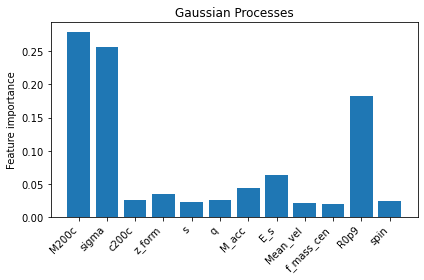

In [17]:
importances_GPR = np.array(permutation_importance(GPR_model, x_train_s, y_train_s).importances_mean)

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(features, importances_GPR/sum(importances_GPR))
plt.ylabel("Feature importance")
plt.title("Gaussian Processes")
plt.xticks(rotation=45, ha='right')

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/featureimportances_GPR_{prop}.png")


In [18]:
# gaussian process regression quantiles
# 90% confidence interval corresponds to +- 1.65 std
y_pred_GPR_q_lower = y_pred_GPR - 1.65*y_std
y_pred_GPR_q_upper = y_pred_GPR + 1.65*y_std

# calcualte the proportion of points within interval
CI_frac_GPR = ((y_pred_GPR_q_lower <= y_test) & (y_pred_GPR_q_upper >= y_test)).sum()
CI_frac_GPR /= len(y_pred_GPR)
print(CI_frac_GPR)



0.9018004866180048


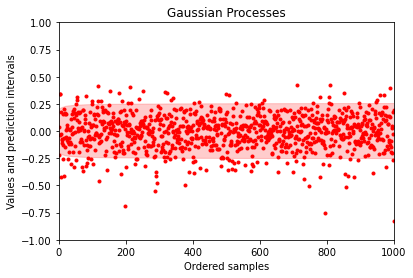

In [30]:
interval = y_pred_GPR_q_upper - y_pred_GPR_q_lower
sort_ind = np.argsort(interval)
upper = y_pred_GPR_q_upper[sort_ind]
lower = y_pred_GPR_q_lower[sort_ind]

# center so mean is at 0
mean = (upper+lower)/2
upper -= mean
lower -= mean

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(y_test[sort_ind] - mean, "r.")
plt.fill_between(np.arange(len(upper)), lower, upper, alpha=0.2, color="r")
plt.xlabel("Ordered samples")
plt.ylabel("Values and prediction intervals")
plt.title("Gaussian Processes")

plt.xlim(0, 1000)

if save_figs:
    plt.savefig(f"Figures/confidenceintervals_GPR_{prop}.png")

plt.show()

R2 score: 0.9477302462022568
correlation: 0.973559191957
mean squared error: 0.02387639554847789


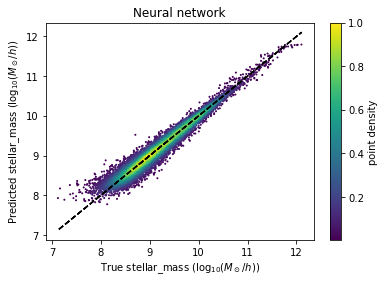

In [20]:
start = time.time()

MLP_model = MLPRegressor(hidden_layer_sizes=(50, 10, 5), activation="logistic", solver="adam")

# Train
MLP_model.fit(x_train, y_train)

# Predict
y_pred_MLP = MLP_model.predict(x_test)

t_MLP = time.time() - start

# calculate performance measures
r2_MLP = r2_score(y_test, y_pred_MLP)
print(f"R2 score: {r2_MLP}")

corr_MLP = np.corrcoef(y_test, y_pred_MLP)[0,1]
print(f"correlation: {corr_MLP}")

mse_MLP = mean_squared_error(y_test, y_pred_MLP)
print(f"mean squared error: {mse_MLP}")

# Plot true vs predicted
fig = plt.figure()
fig.patch.set_facecolor("white")

if plot_densities:
    if sample_size > 1:
        idx = np.random.choice(y_test.shape[0], size=sample_size, replace=False)
        xplot = y_test[idx]
        yplot = y_pred_MLP[idx]
    else:
        xplot = y_test.copy()
        yplot = y_pred_MLP.copy()

    # calculate densities
    xy = np.vstack([xplot, yplot])
    z = gaussian_kde(xy)(xy)

    # plot
    im = plt.scatter(xplot, yplot, s=1, c=z/max(z))
    plt.plot(xplot, xplot, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Neural network")

    cbar = fig.colorbar(im)
    cbar.set_label("point density")

else:
    plt.scatter(y_test, y_pred_GPR, s=1)
    plt.plot(y_test, y_test, c="k", ls="--")
    plt.xlabel("True " + prop + unit)
    plt.ylabel("Predicted " + prop + unit)
    plt.title("Neural network")

if save_figs:
    plt.savefig(f"Figures/truevspred_MLP_{prop}.png")

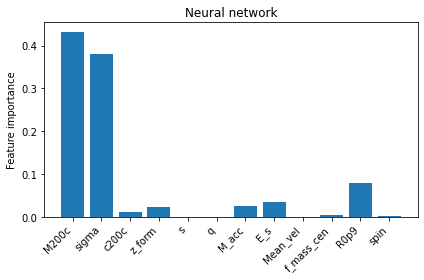

In [21]:
# feature importances
importances_MLP = np.array(permutation_importance(MLP_model, x_train, y_train).importances_mean)

# plot feature importances
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(features, importances_MLP/sum(importances_MLP))
plt.ylabel("Feature importance")
plt.title("Neural network")
plt.xticks(rotation=45, ha='right')

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/featureimportances_MLP_{prop}.png")

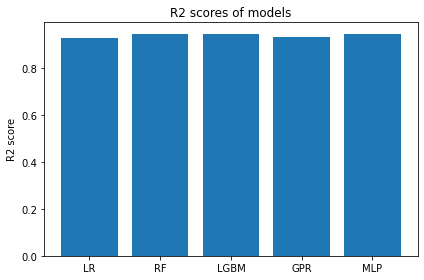

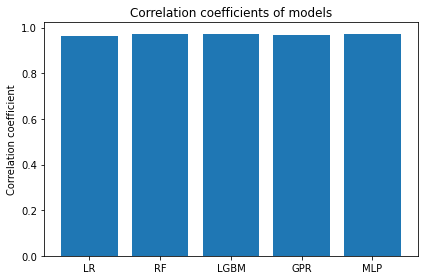

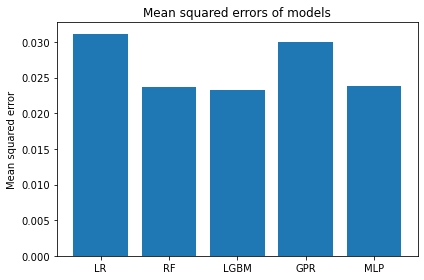

In [22]:
# plot performance measures
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(["LR", "RF", "LGBM", "GPR", "MLP"], [r2_LR, r2_RF, r2_LGBM, r2_GPR, r2_MLP])
plt.ylabel("R2 score")
plt.title("R2 scores of models")

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/r2_{prop}.png")

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(["LR", "RF", "LGBM", "GPR", "MLP"], [corr_LR, corr_RF, corr_LGBM, corr_GPR, corr_MLP])
plt.ylabel("Correlation coefficient")
plt.title("Correlation coefficients of models")

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/corr_{prop}.png")

fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(["LR", "RF", "LGBM", "GPR", "MLP"], [mse_LR, mse_RF, mse_LGBM, mse_GPR, mse_MLP])
plt.ylabel("Mean squared error")
plt.title("Mean squared errors of models")

if save_figs:
    plt.tight_layout()
    plt.savefig(f"Figures/mse_{prop}.png")

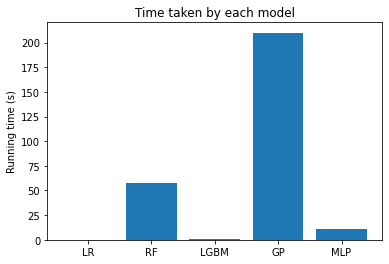

In [23]:
# plot running times
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.bar(["LR", "RF", "LGBM", "GP", "MLP"], [t_LR, t_RF, t_LGBM, t_GPR, t_MLP])
plt.ylabel("Running time (s)")
plt.title("Time taken by each model")

if save_figs:
    plt.savefig(f"Figures/runningtimes_{prop}.png")



In [24]:
# write performance measures to file
with open("Results/results.txt", "a") as f:
    f.write(prop)
    f.write("\n")
    f.write("\t".join([str(i) for i in [r2_LR, r2_RF, r2_LGBM, r2_GPR, r2_MLP]]))
    f.write("\n")
    f.write("\t".join([str(i) for i in [corr_LR, corr_RF, corr_LGBM, corr_GPR, corr_MLP]]))
    f.write("\n")
    f.write("\t".join([str(i) for i in [mse_LR, mse_RF, mse_LGBM, mse_GPR, mse_MLP]]))
    f.write("\n")
    f.write("\t".join([str(i) for i in [t_LR, t_RF, t_LGBM, t_GPR, t_MLP]]))
    f.write("\n")
    f.write("\t".join([str(i) for i in [CI_frac_LR, CI_frac_RF, CI_frac_LGBM, CI_frac_GPR]]))
    f.write("\n")
    